### 1. Simulations of Brownian Geometrical Motion

The GBM model for asset price $S_t$ is given by the following SDE:

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

Where:
- $S_t$: asset price at time $t$
- $\mu$: drift (expected return)
- $\sigma$: volatility of the asset
- $W_t$: standard Brownian motion
- $dW_t \sim \mathcal{N}(0, dt)$

The solution to the GBM SDE is:

$$S_t = S_0 \exp\left( \left(\mu - \frac{1}{2} \sigma^2\right)t + \sigma W_t \right)$$

This implies:

$$\ln(S_t) \sim \mathcal{N}\left( \ln(S_0) + \left(\mu - \frac{1}{2} \sigma^2\right)t, \sigma^2 t \right)$$

So, $S_t$ follows a **log-normal distribution**.

#### 1.1 Euler-Maruyama Method

We can’t simulate continuous Brownian motion directly, so we discretize time $t \in [0, T]$ into $N$ steps of size $\Delta t = T/N$, and simulate the asset price incrementally.

Euler-Maruyama method is the simplest way to simulate SDEs:

$$S_{n+1} = S_n + \mu S_n \Delta t + \sigma S_n \Delta W_n$$

Where:

$$\Delta W_n = \sqrt{\Delta t} \cdot Z_n, \quad Z_n \sim \mathcal{N}(0, 1)$$

Properties:
- Strong convergence of order 0.5
- Weak convergence of order 1.0
- May be inaccurate for small $\Delta t$

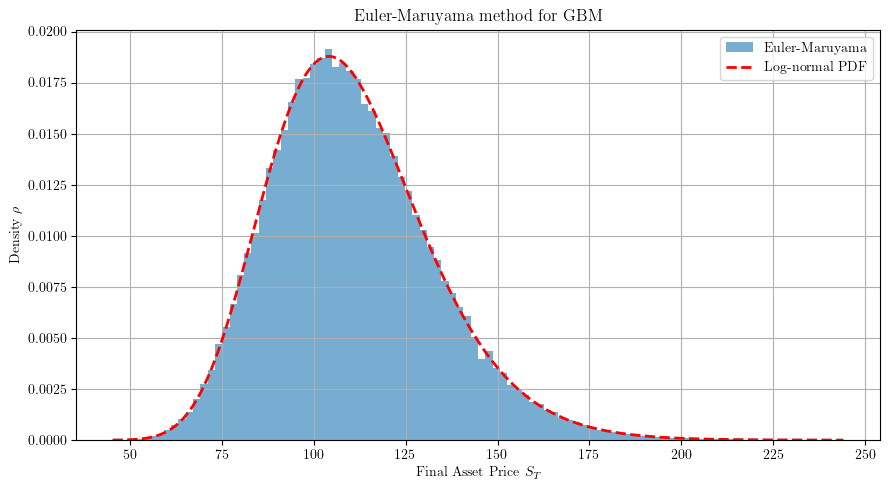

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Parameters
S0 = 100       # Initial asset price
mu = 0.1       # Drift
sigma = 0.2    # Volatility
T = 1.0        # Time to maturity
N = 1000       # Time steps
M = 100000     # Number of simulated paths

dt = T / N

S = np.zeros((M, N+1))
S[:, 0] = S0

for n in range(N):
    Z = np.random.randn(M)
    dW = np.sqrt(dt) * Z
    S[:, n+1] = S[:, n] + mu * S[:, n] * dt + sigma * S[:, n] * dW

mu_adj = np.log(S0) + (mu - 0.5 * sigma**2) * T
sigma_adj = sigma * np.sqrt(T)

plt.figure(figsize=(9, 5))
plt.hist(S[:, -1], bins=100, density=True, alpha=0.6, label='Euler-Maruyama')

x_vals = np.linspace(min(S[:, -1]), max(S[:, -1]), 1000)
pdf_vals = lognorm.pdf(x_vals, s=sigma_adj, scale=np.exp(mu_adj))
plt.plot(x_vals, pdf_vals, 'r--', linewidth=2, label='Log-normal PDF')

plt.title(r'Euler-Maruyama method for GBM')
plt.xlabel(r'Final Asset Price $S_T$')
plt.ylabel(r'Density $\rho$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1.2 Milstein Method

Milstein adds an additional term that accounts for the Itô correction (due to the non-zero second derivative of the diffusion term). Here's how it can be derived.

Using Itô's lemma for $f=\ln{S_n}$, we get:

$$ d \ln S_t = \left( \mu - \frac{1}{2} \sigma^2 \right) dt + \sigma dW_t $$

The solution is:

\begin{align*}
    S_{t+\Delta t} &= S_t \exp\left\{ \int_t^{t+\Delta t} \left( \mu - \frac{1}{2} \sigma^2 \right) du + \int_t^{t+\Delta t} \sigma \, dW_u \right\} \\
    &\approx S_t \left( 1 + \mu \Delta t - \frac{1}{2} \sigma^2 \Delta t + \sigma \Delta W_t + \frac{1}{2} \sigma^2 (\Delta W_t)^2 \right) + \mathcal{O} \left(\Delta t^{-3/2} \right) \\
    &= S_t + \mu S_t\Delta t + \sigma S_t\Delta W_t + \frac{1}{2} \sigma^2 S_t \left( (\Delta W_t)^2 - \Delta t \right)
\end{align*}

At the end we get E-M solution plus Itô's correction:

$$ S_{n+1} = S_n + \mu S_n \Delta t + \sigma S_n \Delta W_n + \frac{1}{2} \sigma^2 S_n \left((\Delta W_n)^2 - \Delta t\right) $$

Properties:
- Still simple like Euler-Maruyama, but:
- Stronger convergence (order 1.0 vs 0.5 for Euler-Maruyama)
- More accurate simulation of sample paths

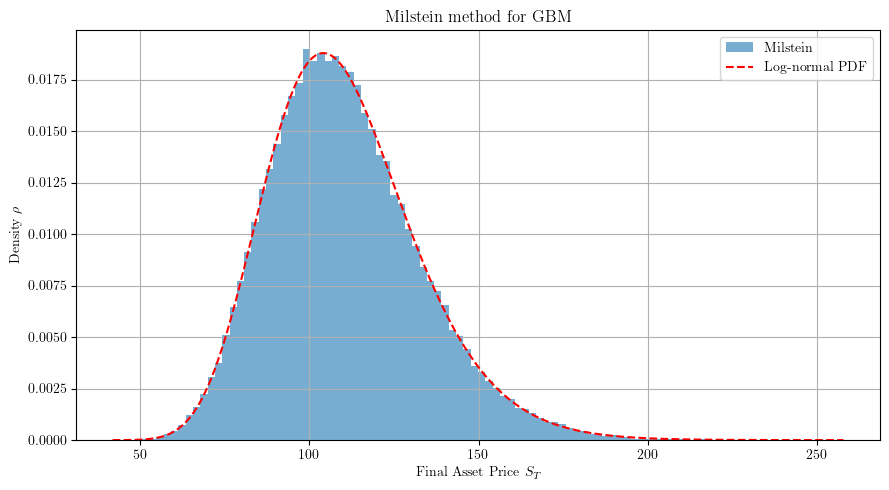

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Parameters
S0 = 100       # Initial asset price
mu = 0.1       # Drift
sigma = 0.2    # Volatility
T = 1.0        # Time horizon
N = 1000       # Time steps
M = 100000     # Number of paths

dt = T / N
t = np.linspace(0, T, N+1)

S = np.zeros((M, N+1))
S[:, 0] = S0

for n in range(N):
    dW = np.random.normal(0, np.sqrt(dt), size=M)
    S[:, n+1] = S[:, n] + mu * S[:, n] * dt + sigma * S[:, n] * dW + 0.5 * sigma**2 * S[:, n] * (dW**2 - dt)

plt.figure(figsize=(9, 5))

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
})

plt.hist(S[:, -1], bins=100, density=True, alpha=0.6, label='Milstein')

mean_ln = np.log(S0) + (mu - 0.5 * sigma**2) * T
std_ln = sigma * np.sqrt(T)
x_vals = np.linspace(S[:, -1].min(), S[:, -1].max(), 1000)
pdf_vals = lognorm.pdf(x_vals, s=std_ln, scale=np.exp(mean_ln))
plt.plot(x_vals, pdf_vals, 'r--', label='Log-normal PDF')

plt.xlabel(r'Final Asset Price $S_T$')
plt.ylabel(r'Density $\rho$')
plt.title('Milstein method for GBM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 1.3 Compare the convergence

Let us define weak and strong convergence;

**Strong convergence**

Let $X(t)$ be the true solution to the SDE, and $X_n$ be the numerical approximation at time $t_n$. The method is **strongly convergent of order $\gamma$** if there exists a constant $C$ such that:

$$ \mathbb{E}\left[ |X(T) - X_N| \right] \leq C \cdot \Delta t^\gamma $$

for $\Delta t = T/N$, sufficiently small.

**Weak convergence**

Let $\phi$ be any sufficiently smooth test function, for example, the arithmetic mean. The method is weakly convergent of order $\beta$ if there exists a constant $C$ such that:

$$ | \mathbb{E}[\phi(X(T))] - \mathbb{E}[\phi(X_N)] | \leq C \cdot \Delta t^\beta $$

In the example below, we aim to show that:
- the Euler-Maruyama method has a weak convergence order of 1.0 and a strong convergence order of 0.5
- in case of the Milstein method, both strond and weak convergence order is 1.0

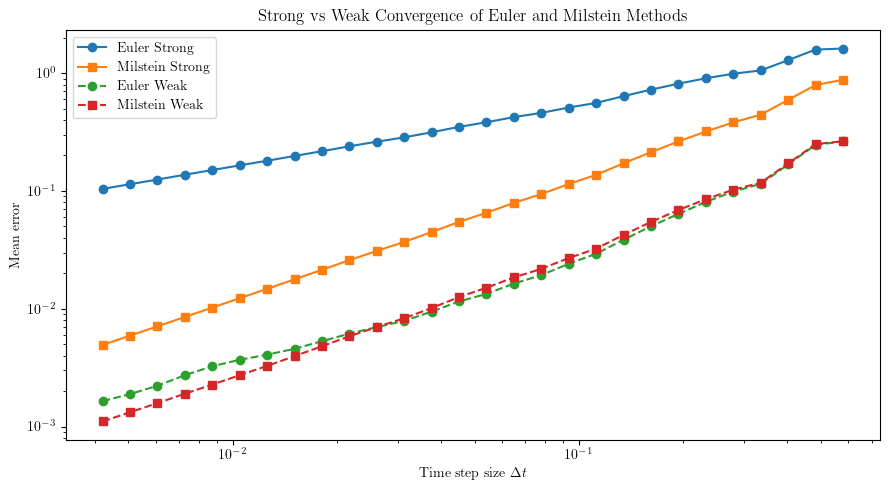

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100
mu = 0.1
sigma = 0.2
T = 1.0
M = 50000
dt_values = [1.2 ** i for i in range(-30, -2)]

strong_errors_euler = []
weak_errors_euler = []
strong_errors_milstein = []
weak_errors_milstein = []

for dt in dt_values:

    t_array = np.arange(dt, T + dt, dt)

    N = len(t_array)

    err_euler = np.zeros(N)
    err_milstein = np.zeros(N)

    S_exact_array_sum = np.zeros(N)
    S_euler_array_sum = np.zeros(N)
    S_milstein_array_sum = np.zeros(N)

    for sample in range(M):

        np.random.seed(sample)
        dW = np.sqrt(dt) * np.random.randn(N)
        W = np.cumsum(dW)

        S_exact_array = S0 * np.exp((mu - 0.5 * sigma**2) * t_array + sigma * W)

        S_euler_array = []
        S_milstein_array = []

        S_euler = S0
        S_milstein = S0

        for step in range(N):
            # Euler-Maruyama
            S_euler += mu * S_euler * dt + sigma * S_euler * dW[step]

            # Milstein
            S_milstein += mu * S_milstein * dt + sigma * S_milstein * dW[step] + 0.5 * sigma ** 2 * S_milstein * (dW[step] ** 2 - dt)

            S_euler_array.append(S_euler)
            S_milstein_array.append(S_milstein)

        err_euler  += abs(S_exact_array - S_euler_array)
        err_milstein  += abs(S_exact_array - S_milstein_array)
        
        S_exact_array_sum += S_exact_array
        S_euler_array_sum += S_euler_array
        S_milstein_array_sum += S_milstein_array

    strong_errors_euler.append(np.mean(err_euler / M))
    strong_errors_milstein.append(np.mean(err_milstein / M))

    weak_errors_euler.append(np.mean(abs(S_euler_array_sum - S_exact_array_sum) / M))
    weak_errors_milstein.append(np.mean(abs(S_milstein_array_sum - S_exact_array_sum) / M))


plt.figure(figsize=(9, 5))

plt.loglog(dt_values, strong_errors_euler, 'o-', label="Euler Strong")
plt.loglog(dt_values, strong_errors_milstein, 's-', label="Milstein Strong")
plt.loglog(dt_values, weak_errors_euler, 'o--', label="Euler Weak")
plt.loglog(dt_values, weak_errors_milstein, 's--', label="Milstein Weak")
plt.xlabel(r"Time step size $\Delta t$")
plt.ylabel("Mean error")
plt.title("Strong vs Weak Convergence of Euler and Milstein Methods")
plt.legend()
plt.tight_layout()
plt.show()